In [570]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from numpy import random
import scipy
from scipy.linalg import expm, sinm, cosm
from qutip import *
from scipy.integrate import solve_ivp


# Defining the system
k = 4 # k-order squeezing drive 
m = 4 # Multiphoton damping
systemSize = 30 # Truncated Hilbert space 

#Defining operators 
a = qt.destroy(systemSize) # Lowering operator
aM = a**m 

aDagger = qt.create(systemSize) # Raising operator 
aDaggerM = aDagger**m

n_hat = aDagger* a # Number operator 
M_joint = (aDagger**m)*(a**m) # Combination of raising/lowering operators 
identity = qt.qeye(systemSize) # Identity operator 

# Defining parameters 
gamma1 = 1    # Single level decay rate 
gammaM = 0.1 # Multilevel decay rate 
delta = 0.4   # Detuning 
eta = 0.5
theta = 0
#beta = 3
#beta = 2 * eta/gammaM

# Defining master equation 

# Hamiltonian
Hamiltonian = (delta * n_hat) + (1j * eta) * (a**k * np.exp(1j * theta * k) - aDagger**k * np.exp(-1j * theta * k))


# Effective hamiltonian 

H_eff = Hamiltonian - 1j/2 * ((gamma1 * aDagger * a) + (gammaM * aDaggerM * aM))
H_eff_dag = Hamiltonian + 1j/2 * ((gamma1 * aDagger * a) + (gammaM * aDaggerM * aM))
#L_0 (rho) = -1j * H_eff (rho) + 1j * (rho) * H_eff_dag

vac = basis(systemSize, 0) # Vacuum state 
Psi_sup = (basis(systemSize, 0) + basis(systemSize, 1)).unit()

Psi_0 = basis(systemSize, 3) # 3 photons in cavity
Psi_t = Psi_0
Rho_0 = (Psi_0 * Psi_0.dag())

mod_sq = Psi_0.dag() * Psi_0
mod_sq = mod_sq.real
print(mod_sq)

time_list = np.linspace(0, 0.1, 100000)

# Quantum jump trajectory 

r = random.rand() # Generate random number between 0 and 1 

# Empty arrays to append results to 

Psi_t_evol = [] 
mod_sq_array = []
Pi_1_array = []
Pi_M_array = []
jump_counter_array1 = np.zeros(len(time_list))
jump_counter_arrayM = np.zeros(len(time_list))
a_mod_array = []

jump_counter_tot = 0
jump_counter1 = 0 # Tells us the total amount of single photon jumps 
jump_counterM = 0 # Tells us the total amount of multi-photon jumps

jump_time_index = 0 # Variable to track index of time_list after each jump

for i in range(len(time_list)):
    
    mod_sq_array.append(mod_sq)
    Psi_t_evol.append(Psi_t)

    # Tracker for progress 
    tracker = i%10000 
    if tracker == 0:
        print('index='+str(i))
        #print('modulus squared =' +str(mod_sq))
        #print('r = ' +str(r))
        print('Jump counter ='+str(jump_counter_tot))
        print('')
    
    # Randomly generate time at which jump occurs
    # time_list[i]-time_list[time_loc] 'resets' the evolution of the Hamiltonian after eahc quantum jump
    
    Ev_Op = (-1j * H_eff * (time_list[i] - time_list[jump_time_index])).expm()  # Qobj's expm
    Psi_t = Ev_Op * Psi_t  # Evolve the state under the effective Hamiltonian 

    mod_sq = Psi_t.dag() * Psi_t
    mod_sq = mod_sq.real

    # Jump occurs if condition met
    if mod_sq < r:
        jump_time_index = i 
        jump_counter_tot += 1
        
        # Calculate probability of 2 different possible jumps occuring
        Pi_1 = Psi_t.dag() * aDagger * a * Psi_t  # Expectation value of single photon jump 
        Pi_M = Psi_t.dag() * aDaggerM * aM * Psi_t # Expectation value of multi photon jump 
        
        ProbPi_1 = Pi_1 / (Pi_1 + Pi_M) # Probability of single photon jump occuring 
        ProbPi_1 = ProbPi_1.real # Deals with python reprsenting imaginary component as very small not zero (10^-19 for example)
        
        ProbPi_M = Pi_M / (Pi_1 + Pi_M) # Probability of multi photon jump occuring
        ProbPi_M = ProbPi_M.real

        rr = random.rand() 

        if ProbPi_1 < rr:

            Psi_t = a * Psi_t /np.sqrt(Pi_1)
            jump_counter1 += 1
            jump_counter_array1[i] = 1

        else:

            Psi_t = aM * Psi_t /np.sqrt(Pi_M)
            jump_counterM += 1
            jump_counter_arrayM[i] = 1

        r = random.rand() # Generate new random number between 0 and 1 for next random decay


print(jump_counter_tot) 
print(jump_counter1) 
print(jump_counterM)



1.0
index=0
Jump counter =0

index=10000
Jump counter =22

index=20000
Jump counter =47

index=30000
Jump counter =76

index=40000
Jump counter =102

index=50000
Jump counter =137

index=60000
Jump counter =162

index=70000
Jump counter =187

index=80000
Jump counter =212

index=90000
Jump counter =236

256
251
5


Total quantum jumps=256
Number of single photon decays=251
Number of multi-photon decays=5


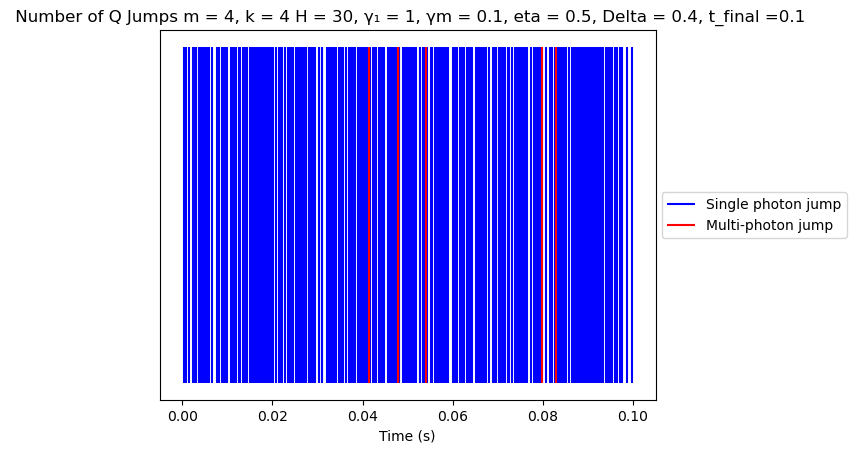

In [572]:
# Plots indicating when jumps occur 

print('Total quantum jumps=' +str(jump_counter_tot)) 
print('Number of single photon decays=' +str(jump_counter1)) 
print('Number of multi-photon decays=' +str(jump_counterM)) 


# First stem plot (Blue)
stem1 = plt.stem(time_list, jump_counter_array1, linefmt='b-', basefmt=" ", markerfmt="")
stem1[1].set_label('Single photon jump')  # Set label on stem lines

# Second stem plot (Red)
stem2 = plt.stem(time_list, jump_counter_arrayM, linefmt='r-', basefmt=" ", markerfmt="")
stem2[1].set_label('Multi-photon jump')  # Set label on stem lines

# Show legend
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.xlabel('Time (s)')
plt.yticks([])
plt.title(f' Number of Q Jumps m = {m}, k = {k} H = {systemSize}, γ₁ = {gamma1}, γm = {gammaM}, eta = {eta}, Delta = {delta}, t_final ={time_list[-1]}')
#plt.savefig(f' Number of Q Jumps m = {m}, k = {k} H = {systemSize}, γ₁ = {gamma1}, γm = {gammaM}, eta = {eta}, Delta = {delta}, t_final ={time_list[-1]}.png',bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

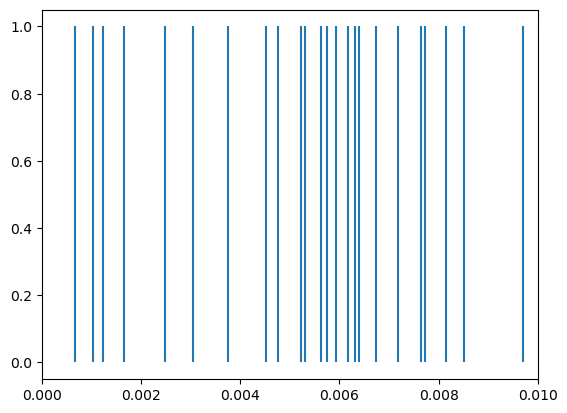

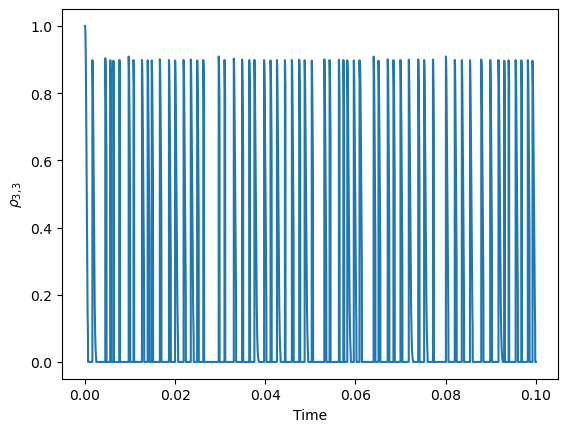

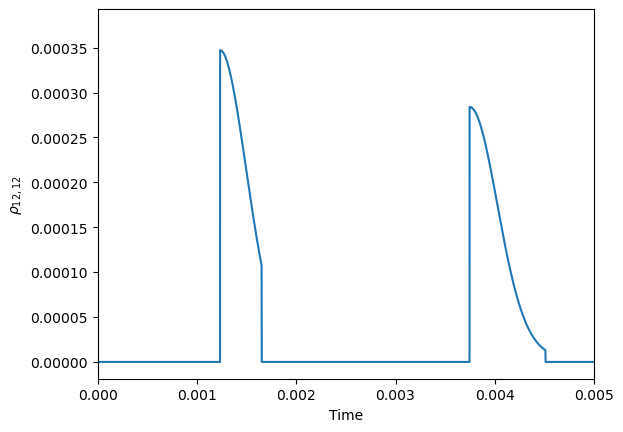

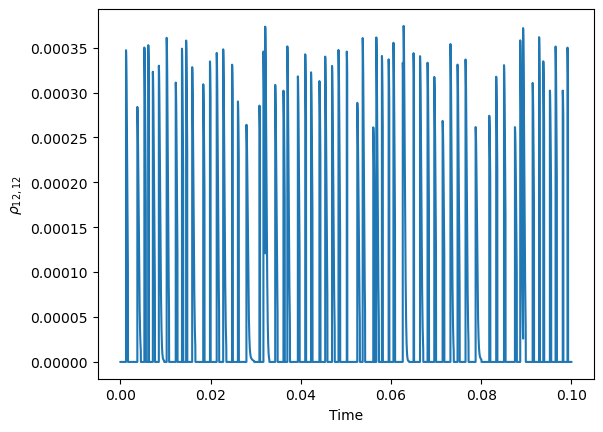

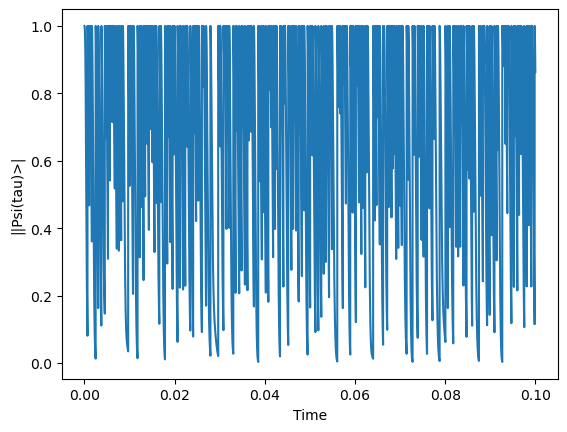

<Figure size 640x480 with 0 Axes>

In [510]:


Fock3 = qt.fock_dm(systemSize, 3)
Fock3_evol = [qt.expect(Fock3, ket)for ket in Psi_t_evol]
plt.plot(time_list, Fock3_evol)
#plt.xlim([0,0.001])
plt.xlabel('Time')
plt.ylabel(r'$\rho_{3,3}$')
plt.figure()

Fock12 = qt.fock_dm(systemSize, 12)
Fock12_evol = [qt.expect(Fock12, ket)for ket in Psi_t_evol]
plt.plot(time_list, Fock12_evol)
plt.xlim([0,0.005])
plt.xlabel('Time')
plt.ylabel(r'$\rho_{12,12}$')
plt.figure()

plt.plot(time_list, Fock12_evol)
plt.xlabel('Time')
plt.ylabel(r'$\rho_{12,12}$')
#plt.xlim([0,10])
#plt.ylim([0,0.2])
plt.figure()

plt.plot(time_list, mod_sq_array)
#plt.xlim([0.002,0.003])
#plt.ylim([0,0.2])
plt.xlabel('Time')
plt.ylabel('||Psi(tau)>|')
plt.figure()



In [500]:
print(Psi_t)
print(mod_sq)

Quantum object: dims=[[25], [1]], shape=(25, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.69448767e-01-2.40408141e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.72753340e-01+1.38013660e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 5.16557662e-02-1.97167282e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.31403697e-03+1.27803410e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 1.21978017e-04-4.72590545e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-2.90885184e-06+1.12980467e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]]
0.8109100037214337
